<a href="https://colab.research.google.com/github/dowrave/RoadToImageSeg_GAN/blob/main/220511_Adversarial_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 적대적 샘플(Adversarial Example)
- 신경망을 혼란시킬 목적으로 만든 특수한 입력.
- 머신러닝 모델은 자연 발생한 샘플은 잘 대응하지만 이런 샘플에는 잘 대응하지 못함

- 신경망 공격 기술에 여러 종류가 있다.
- 이번 튜토리얼에서는 화이트 박스(White Box) 공격 기술에 속하는 FGSM을 다룬다.
  - 화이트 박스 : 공격자가 대상 모델의 모든 파라미터 값에 접근할 수 있다는 가정 하에 이루어지는 공격
  - FGSM(Fast Gradient Sign Method) : 그래디언트를 이용해 적대적 샘플을 생성하는 기법. 입력 이미지에 대한 손실 함수의 그래디언트를 계산, 손실을 최대화하는 이미지를 생성한다.
    - A.E.는 각 픽셀의 손실에 대한 기여도를 그래디언트를 통해 계산 -> 기여도에 따라 픽셀 값에 왜곡을 추가하여 생성. 기여도는 Chain Rule을 이용해 그래디언트를 계산한다. 
    - 대상 모델(학습을 마친 모델)은 더 이상 학습하지 않기 때문에 모델의 가중치 값은 유지된다.

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

### 사전 훈련된 MobileNetV2 모델과 imageNet의 클래스 이름들을 불러온다.

In [3]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top = True,
                                                    weights = 'imagenet')
pretrained_model.trainable = False

# ImageNet 클래스 레이블
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14548992/14536120 [==============================] - 0s 0us/step


In [4]:
# 이미지 전달 전처리 
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image / 255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

# 확률 벡터에서 레이블 추출
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [6]:
# 레브라도 리트리버 샘플 이미지
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)

# 이미지 디코딩 - 전처리 - 입력으로 넣음
image = tf.image.decode_image(image_raw)
image = preprocess(image)
image_probs = pretrained_model.predict(image)

98304/83281 [===================================] - 0s 0us/step


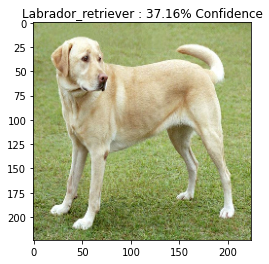

In [8]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence * 100))
plt.show()

## 적대적 이미지 생성하기
1. FGSM 실행

In [9]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # 입력 이미지에 대한 손실 함수 기울기
  gradient = tape.gradient(loss, input_image)

  # 왜곡 생성 : 그래디언트 부호를 얻음
  signed_grad = tf.sign(gradient)
  return signed_grad


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


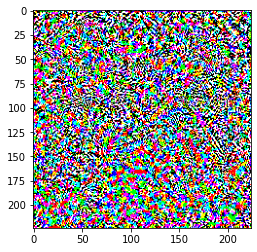

In [14]:
# 왜곡 시각화
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])

In [15]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0])
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence * 100))

  plt.show()

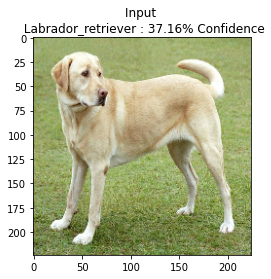

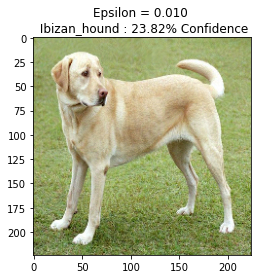

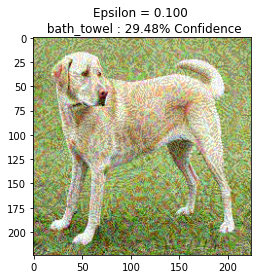

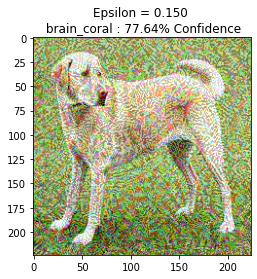

In [16]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps * perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])